# Fruit Classification

https://www.kaggle.com/datasets/alihasnainch/fruits-dataset-for-classification/data

In [29]:
import os
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
data_dir = os.getcwd()
dataset_path = Path(os.path.join(data_dir, 'Dataset'))
models_path = Path(os.path.join(data_dir, 'Models'))

In [3]:
# List all JPEG images in the dataset directory and its subdirectories
images_paths_list = list(dataset_path.glob("**/*.jpg"))

# List all labels (subdirectories) in the dataset directory
labels = sorted([item.name for item in dataset_path.iterdir() if item.is_dir()])


print(f'Total Labels = {len(labels)}')
print(f'Total Images = {len(images_paths_list)}')

Total Labels = 6
Total Images = 1655


In [4]:
for label in labels:
    images_label = list(Path(os.path.join(dataset_path, label)).glob("*.jpg"))
    print(f'* {label}: {len(images_label)} images\n')

* Fresh Peaches: 250 images

* Fresh Pomegranates: 311 images

* Fresh Strawberries: 250 images

* Rotten Peach: 343 images

* Rotten Pomegranates: 250 images

* Rotten Strawberries: 251 images



In [5]:
def plot_dataset_example(dataset_path, num_images_per_category):
    # List all labels (subdirectories) in the dataset directory
    labels = sorted([item.name for item in dataset_path.iterdir() if item.is_dir()])

    # Create a matplotlib figure
    num_rows = len(labels)
    num_cols = num_images_per_category
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 10))

    for i, label in enumerate(labels):
        images_label = list((dataset_path / label).glob("*.jpg"))
        # Randomly select images from each label
        selected_images = random.sample(images_label, min(num_images_per_category, len(images_label)))
        for j, image_path in enumerate(selected_images):
            # Open the image using PIL
            img = Image.open(image_path)
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(label)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

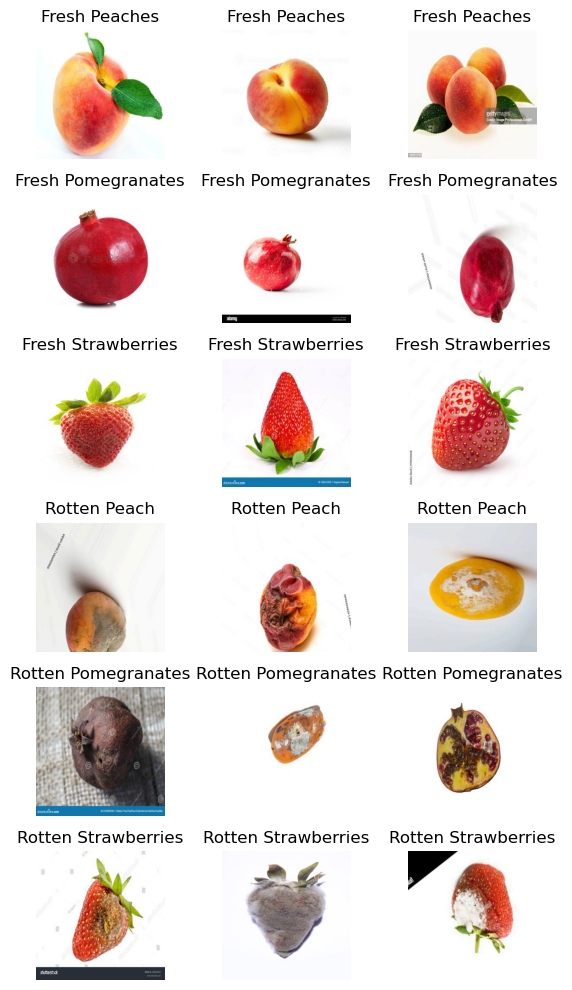

In [6]:
plot_dataset_example(dataset_path,3)

In [7]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, train_pct=0.8, val_pct=0.1, test_pct=0.1, train_transform=None, val_test_transform=None):
        self.data_dir = data_dir
        self.dataset_path = Path(os.path.join(data_dir, 'Dataset'))
        self.images_paths_list = list(self.dataset_path.glob("**/*.jpg"))
        self.labels = sorted([item.name for item in self.dataset_path.iterdir() if item.is_dir()])
        self.train_pct = train_pct
        self.val_pct = val_pct
        self.test_pct = test_pct
        self.train_transform = train_transform
        self.val_test_transform = val_test_transform
        self.load_dataset()
        self.split_dataset()

    def load_dataset(self):
        self.dataset = []
        for img_path in self.images_paths_list:
            label = img_path.parent.name
            self.dataset.append((img_path, label))

    def split_dataset(self):
        random.shuffle(self.dataset)
        total_size = len(self.dataset)
        train_size = int(total_size * self.train_pct)
        val_size = int(total_size * self.val_pct)
        test_size = total_size - train_size - val_size

        self.dataset_train = self.dataset[:train_size]
        self.dataset_valid = self.dataset[train_size:train_size + val_size]
        self.dataset_test = self.dataset[-test_size:]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Apply appropriate transformation based on dataset type
        if 'train' in img_path.parts:
            transform = self.train_transform if self.train_transform else self.val_test_transform
        else:
            transform = self.val_test_transform
            
        if transform:
            image = transform(image)
        
        label = torch.tensor(self.labels.index(label))  # Convert label to tensor
        return image, label

    def get_datasets(self):
        # Apply transformation to all images to convert them into tensors
        transform_to_tensor = transforms.ToTensor()
        dataset_train = [(transform_to_tensor(Image.open(img_path).convert("RGB")), torch.tensor(self.labels.index(label))) for img_path, label in self.dataset_train]
        dataset_valid = [(transform_to_tensor(Image.open(img_path).convert("RGB")), torch.tensor(self.labels.index(label))) for img_path, label in self.dataset_valid]
        dataset_test = [(transform_to_tensor(Image.open(img_path).convert("RGB")), torch.tensor(self.labels.index(label))) for img_path, label in self.dataset_test]
        
        return dataset_train, dataset_valid, dataset_test

In [8]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Define data directory
data_dir = os.getcwd()

# Create dataset object
fruit_dataset = FruitDataset(data_dir, train_pct=0.8, val_pct=0.1, test_pct=0.1,
                              train_transform=train_transform, val_test_transform=val_test_transform)

# Get the split datasets
dataset_train, dataset_valid, dataset_test = fruit_dataset.get_datasets()

# Create data loaders
loader_train = DataLoader(dataset_train, batch_size=40, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=32)
loader_test = DataLoader(dataset_test, batch_size=32)


In [10]:
# Iterate through a few samples in dataset_train and print their types
for i in range(5):  # Print the types of the first 5 samples
    sample = dataset_train[i]
    print(f"Sample {i+1}: Image type - {type(sample[0])}, Label type - {type(sample[1])}")


Sample 1: Image type - <class 'torch.Tensor'>, Label type - <class 'torch.Tensor'>
Sample 2: Image type - <class 'torch.Tensor'>, Label type - <class 'torch.Tensor'>
Sample 3: Image type - <class 'torch.Tensor'>, Label type - <class 'torch.Tensor'>
Sample 4: Image type - <class 'torch.Tensor'>, Label type - <class 'torch.Tensor'>
Sample 5: Image type - <class 'torch.Tensor'>, Label type - <class 'torch.Tensor'>


In [11]:
def show_images(dataset, num_images=8, title_fontsize=10):
    # Get a random sample of images from the dataset
    sample = random.sample(dataset, num_images)
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, (image, label) in enumerate(sample):
        # Check if image is a tensor
        if isinstance(image, torch.Tensor):
            # Convert tensor to numpy array and transpose dimensions
            image = image.permute(1, 2, 0).numpy()
            # Undo normalization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)  # Clip to range [0, 1]

        # Plot the image
        axes[i].imshow(image)
        axes[i].set_title(label, fontsize=title_fontsize)
        axes[i].axis('off')
    plt.show()

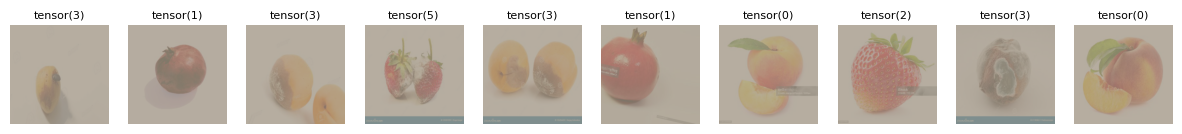

In [12]:
show_images(dataset_train, num_images=10, title_fontsize=8)

## Network

In [13]:
def initialize_model(num_classes):
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

# Initialize the model
num_classes = len(fruit_dataset.labels)
model = initialize_model(num_classes)

/Users/mjg/anaconda3/envs/Torch_New/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mjg/anaconda3/envs/Torch_New/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training Loop

In [21]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [22]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, save_dir=None):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    best_val_accuracy = 0.0
    best_epoch = 0
    best_model_path = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total

        # Save model weights if it has better validation accuracy
        if save_dir and val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch
            # Construct the filename based on validation accuracy and epoch number
            file_name = f'{val_accuracy:.4f}_{epoch+1}.pt'
            save_path = os.path.join(save_dir, file_name)
            torch.save(model.state_dict(), save_path)
            best_model_path = save_path
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')

    if save_dir:
        print(f"Best model saved at epoch {best_epoch+1} with validation accuracy: {best_val_accuracy:.4f}")

    return best_model_path




In [23]:
model_dir = os.path.join(os.getcwd(),'Models')
print(model_dir)

/Users/mjg/Desktop/5. Coding/5. CV/20. CNN/3. Fruit Classification/Models


In [24]:
# After calling the train_model function
best_model_path = train_model(model, criterion, optimizer, loader_train, loader_valid, num_epochs=15, save_dir=model_dir)

if best_model_path:
    # Load the best model
    best_model = initialize_model(num_classes)  # Create a fresh model instance
    best_model.load_state_dict(torch.load(best_model_path))

Epoch [1/15], Train Loss: 0.1734, Val Loss: 0.3062, Val Accuracy: 0.8970
Epoch [2/15], Train Loss: 0.0855, Val Loss: 0.2474, Val Accuracy: 0.9394
Epoch [3/15], Train Loss: 0.0491, Val Loss: 0.2215, Val Accuracy: 0.9333
Epoch [4/15], Train Loss: 0.0484, Val Loss: 0.2170, Val Accuracy: 0.9273
Epoch [5/15], Train Loss: 0.0537, Val Loss: 0.2932, Val Accuracy: 0.9333
Epoch [6/15], Train Loss: 0.0313, Val Loss: 0.2061, Val Accuracy: 0.9455
Epoch [7/15], Train Loss: 0.0330, Val Loss: 0.2190, Val Accuracy: 0.9333
Epoch [8/15], Train Loss: 0.0207, Val Loss: 0.4554, Val Accuracy: 0.9030
Epoch [9/15], Train Loss: 0.0095, Val Loss: 0.1480, Val Accuracy: 0.9455
Epoch [10/15], Train Loss: 0.0072, Val Loss: 0.1663, Val Accuracy: 0.9455
Epoch [11/15], Train Loss: 0.0212, Val Loss: 0.1626, Val Accuracy: 0.9273
Epoch [12/15], Train Loss: 0.0122, Val Loss: 0.1739, Val Accuracy: 0.9273
Epoch [13/15], Train Loss: 0.0334, Val Loss: 0.2683, Val Accuracy: 0.9152
Epoch [14/15], Train Loss: 0.0070, Val Loss: 0.

/Users/mjg/anaconda3/envs/Torch_New/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mjg/anaconda3/envs/Torch_New/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Evaluate model

In [31]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    test_loss /= len(test_loader)

    # Ensure true_labels and predictions are np.arrays to avoid shape mismatch issues
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro')  # For multi-class
    recall = recall_score(true_labels, predictions, average='macro')  # For multi-class
    f1 = f1_score(true_labels, predictions, average='macro')  # For multi-class
    
    # Handling ROC AUC for multi-class
    # Convert true labels to one-hot encoding for multi-class ROC AUC
    num_classes = len(np.unique(true_labels))
    true_labels_one_hot = np.eye(num_classes)[true_labels]
    predictions_one_hot = np.eye(num_classes)[predictions]
    roc_auc = roc_auc_score(true_labels_one_hot, predictions_one_hot, multi_class='ovr')

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Print metrics
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Visualization code remains the same
    
    return accuracy

# After running the test function, saving the model and weights code remains unchanged.


In [32]:
# Get accuracy
accuracy = test(model, loader_test, criterion)

# Define folder to store model paths
current_dir = os.getcwd()
model_folder = 'Models'
models_dir = os.path.join(current_dir, model_folder)

# Define file paths including accuracy at the beginning of the filenames
architecture_path = os.path.join(models_dir, f"{accuracy:.2f}%_model_architecture.pth")
weights_path = os.path.join(models_dir, f"{accuracy:.2f}%_model_weights.pth")

# Save model architecture
torch.save(model, architecture_path)  # Save the entire model including architecture and weights

# Save model weights separately
torch.save(model.state_dict(), weights_path)  # Save only the model weights

Test Loss: 0.1358
Accuracy: 0.9518
Precision: 0.9478
Recall: 0.9498
F1 Score: 0.9475
ROC AUC Score: 0.9702


The evaluation of the model on the test dataset has yielded promising results, underscoring the model's effective performance across a range of metrics for a 6-class classification task. Here is a detailed interpretation of the results obtained:

- **Test Loss (0.1358):** The low test loss indicates that the model has a strong predictive capability, with minimal discrepancy between the predicted outputs and the actual labels. This suggests that the model generalizes well to unseen data.

- **Accuracy (95.18%):** The accuracy metric reflects the model's overall correctness in classifying the test data into the correct categories. An accuracy of 95.18% signifies that the model correctly predicts the class labels for approximately 95 out of every 100 samples in the test dataset, demonstrating its reliability in classification tasks.

- **Precision (94.78%):** Precision measures the model's ability to correctly identify positive instances for each class. A precision of 94.78% indicates that, on average, 94.78% of the predictions made by the model for each class were actually relevant or correct. This high precision is indicative of the model's effectiveness in minimizing false positives across all classes.

- **Recall (94.98%):** The recall score assesses the model's capability to identify all relevant instances for each class. With a recall of 94.98%, the model is able to retrieve nearly 95% of all actual instances of each class from the test dataset. This high recall rate suggests that the model is highly capable of detecting the positive class instances without missing many, minimizing false negatives.

- **F1 Score (94.75%):** The F1 score provides a harmonic mean of precision and recall, offering a balance between the two metrics for each class. An F1 score of 94.75% denotes that the model maintains an excellent balance between precision and recall, ensuring that both the avoidance of false positives and the retrieval of true positives are handled effectively.

- **ROC AUC Score (97.02%):** The ROC AUC score represents the model's ability to distinguish between the classes across all thresholds. A score of 97.02% is indicative of an outstanding performance, showcasing the model's exceptional capability in differentiating between all six classes. This high score implies that the model has a high true positive rate while maintaining a low false positive rate, across various decision thresholds.

In summary, the model exhibits robust performance metrics in classifying a 6-class dataset, highlighted by high accuracy, precision, recall, F1 score, and an outstanding ROC AUC score. These results affirm the model's efficacy and reliability in handling multi-class classification tasks, demonstrating its potential applicability in diverse practical scenarios requiring accurate and reliable classification.